
## Notes


 - ~~Mesure objective de la résolution effective de la version lissée  (cf J. Emmanuel)~~
 - ~~calculer ordre de grandeur des changement de norme si production zero. [1-E3]~~
 - ~~representation graphique du loss de sort de voir les difference à cet ordre de grandeur~~
 - ~~completer la matrice d’image avec les autres modeles [dont Unet]~~
 - ~~mesurer (et ajouter sur plot) la mesure de l’erreur commise si on évaluer 2conv_uv avec ugeo et ssh smoothes —> les ajouter dans la matrice.~~
 - ~~verifier (sur la matrice de plot) l’erreur qu’on fait en prédisant derive à partir de courant géostrophique~~
 - ~~mesurer si conservation de l’intégrale spatiale.~~
 - ~~calculer l’evolution de l’entropie sur blob reference vs blob ML (voir eq. 10 de Zhuang.)~~
 - ~~apprentissage avec DKL —> visualisation dans matrice.~~
 





In [1]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm    
import matplotlib.pyplot as plt
import numpy as np                                                                                                                                                                                  
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)

%load_ext autoreload
%autoreload 2
                                                                                                                                                                                                    
def rmse(y1, y2):                                                                                                                                                                                   
    return np.sqrt(((y1-y2)**2)).mean()    

# Resolved scales

###### RMSE-Based Score

In [7]:
from pathlib import Path
import sys
from myfuncts import rmse_coords

upathlist = Path('/home/anas/MEOM_Workspace/data/raw/Daily2018/').glob('*gridT-2D.nc')
upathlist =sorted(upathlist)


#ds = xr.open_dataset(upathlist[1])

ds = xr.open_mfdataset(upathlist)
ds["sossheig"]=ds["sossheig"].fillna(0)
ds["s_sossheig"]=ds["s_sossheig"].fillna(0)
ds=ds.drop(['time_centered'])
ds=ds.drop(['nav_lat', 'nav_lon'])

#ssh

# temporal rmse
nrmse_t = rmse_coords(ds["sossheig"], ds["s_sossheig"], ["y", "x"], normalized=True)


# temporal stability of the error
recon_err_stability_metric_t = nrmse_t.std().values

# spatial rmse
nrmse_xy = rmse_coords(ds["sossheig"], ds["s_sossheig"], ["time_counter"], normalized=True)


# spatial stability of the error
recon_err_stability_metric_xy = nrmse_xy.std().values


# leaderboard rmse
nrmse_leaderboard = rmse_coords(ds["sossheig"], ds["s_sossheig"], None, normalized=True)


print(f"Leaderboard RMSE score = {np.round(nrmse_leaderboard.values, 2)}")
print(f"Error Variability (Temporal) = {np.round(recon_err_stability_metric_t, 2)}")
print(f"Error Variability (Spatial) = {np.round(recon_err_stability_metric_xy, 2)}")

print("done")

/home/anas/LIBS/miniconda3/envs/mldrop/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Leaderboard RMSE score = 0.9800000190734863
Error Variability (Temporal) = 0.009999999776482582
Error Variability (Spatial) = 0.019999999552965164
done


In [8]:
from myfuncts import reformat_time
from myfuncts import compute_psd

dt = 1

time_coords = ds.time_counter.values.astype(np.float64)
print(time_coords)
time_coords = reformat_time(
    time_coords, dt
)
time_coords = time_coords.astype(np.float64)
ds["time_counter"] = time_coords
print(time_coords)


[1.2623148e+18 1.2623364e+18 1.2623580e+18 ... 1.2858372e+18 1.2858588e+18
 1.2858804e+18]
[0.00000e+00 2.16000e+13 4.32000e+13 ... 2.35224e+16 2.35440e+16
 2.35656e+16]


In [9]:
psd_coords = ["y", "time_counter", "x"]

ds_psd = compute_psd(ds["sossheig"], ds["s_sossheig"], psd_coords)

ds_psd


/home/anas/LIBS/miniconda3/envs/mldrop/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  2.4s


/home/anas/LIBS/miniconda3/envs/mldrop/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  2.0s


<xarray.Dataset>
Dimensions:            (freq_time_counter: 545, freq_x: 114)
Coordinates:
  * freq_time_counter  (freq_time_counter) float64 4.24e-17 ... 2.311e-14
  * freq_x             (freq_x) float64 0.004348 0.008696 ... 0.4913 0.4957
Data variables:
    psd_diff           (freq_time_counter, freq_x) float64 3.979e+11 ... 6.75...
    psd_signal         (freq_time_counter, freq_x) float64 3.647e+14 ... 3.53...
    psd_score          (freq_time_counter, freq_x) float64 0.9989 ... 0.8087

In [10]:
from myfuncts import shortest_resolved_scale
resolved_scales = shortest_resolved_scale(ds_psd)
print(f"Leaderboard:")

for iname, ivalue in resolved_scales.items():
    
    print(f"Spectral Score (Coord: '{iname}') = {ivalue:.3f}")

tab_score = pd.DataFrame(
    dict(name=["baseline"],
         mu_RMSE=[np.round(nrmse_leaderboard.values, 3)],
         std_RMSE=[np.round(recon_err_stability_metric_t, 3)],
         lambda_x_degree=[resolved_scales["freq_x"]],
         Notes = ['gcm_30km'])
)
tab_score

Leaderboard:
Spectral Score (Coord: 'freq_time_counter') = 718166110286119.875
Spectral Score (Coord: 'freq_x') = 2.018


,name,mu_RMSE,std_RMSE,lambda_x_degree,Notes
0,baseline,0.977,0.008,2.017544,gcm_30km


In [13]:
from mpsd import *



from scipy import signal

delta_t  = 0.9434
velocity = 6.77


delta_x=delta_t * velocity
length_scale=1000
npt = int(length_scale / delta_x) 

wavenumber, global_psd_ref = signal.welch(
        np.asarray(ds["sossheig"]).flatten(),
        fs=1.0 / delta_x,
        nperseg=npt    )

wavenumber, global_psd_pred = signal.welch(
        np.asarray(ds["s_sossheig"]).flatten(),
        fs=1.0 / delta_x,
        nperseg=npt    )

#global_psd_ref


/home/anas/MEOM_Workspace/codes/dahu/displaying/mldrop_notebooks/new_abc.py:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot((1. / wavenumber), psd_ref, label="Reference", color="k")
/home/anas/MEOM_Workspace/codes/dahu/displaying/mldrop_notebooks/new_abc.py:18: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot((1. / wavenumber), psd_study, label="Reconstruction", color="lime")


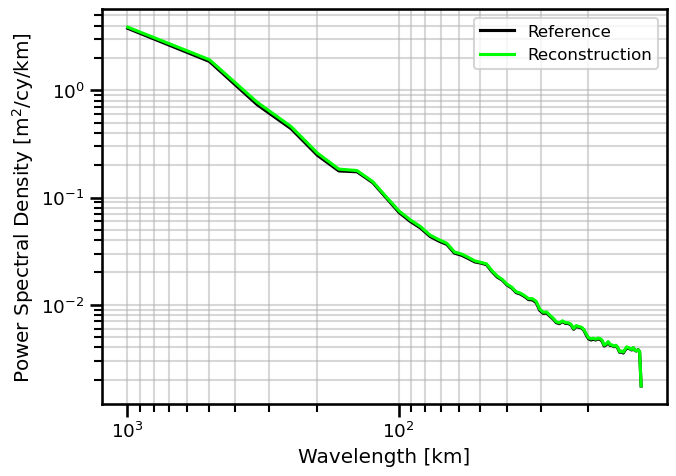

In [14]:
from new_abc import *

fig, ax = plot_psd_spectrum(
    global_psd_ref, 
    global_psd_pred, 
    wavenumber
)


### Order of magnitude if pred = 0

In [2]:
import myfuncts 
def rmse(y1, y2):                                                                                                                                                                                   
    return np.sqrt(((y1-y2)**2)).mean()  

ds=myfuncts.load_5d()

pred0=rmse(ds[-1,1,:,:],0*ds[-1,1,:,:])

print(pred0)
####0.00046393462####

0.00046393462


### 5day advection for all simulations

(45,)


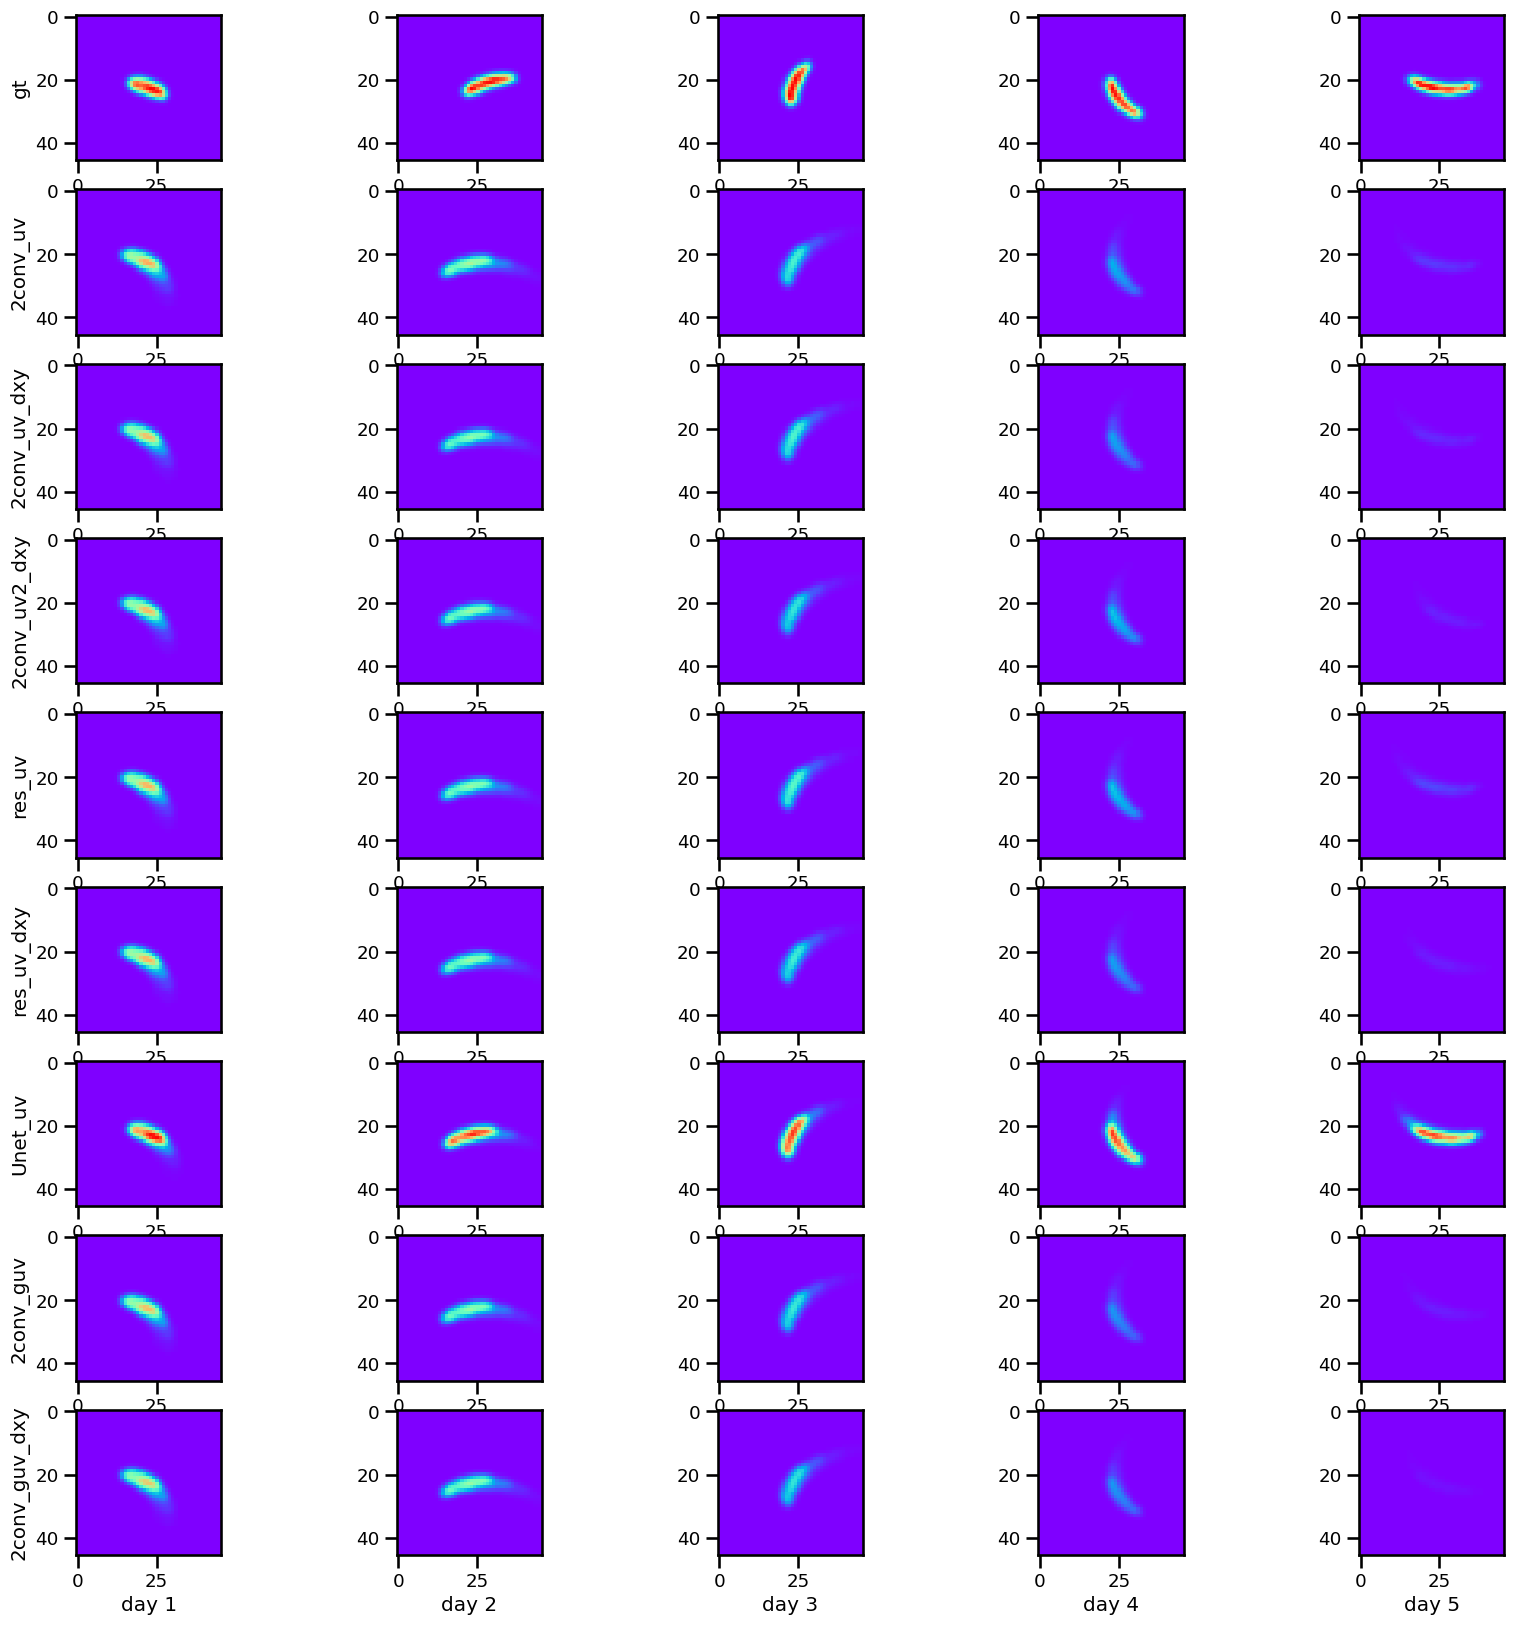

In [30]:
import myfuncts 



ds=myfuncts.load_5ds()
#ds[1][-1,2,:,:]


simulations=['gt','2conv_uv','2conv_uv_dxy', '2conv_uv2_dxy', 'res_uv', 'res_uv_dxy', 'Unet_uv', '2conv_guv', '2conv_guv_dxy']
ds
mmax=1
l=0
k=23
fig, axs = plt.subplots(ncols=5, nrows=9, figsize=(20,20))
axs = axs.ravel()
print(axs.shape)
j=0
# def demo_plot_and_yield():
indices=[4,8,12,16,20]
days=[1,2,3,4,5]
for iax, i  in zip(axs, range(70)):
    j=indices[i%5]
    l=int(i/5)
    #print(l)
    ind = np.unravel_index(np.argmax(ds[l][-1,j,:,:], axis=None), ds[l][-1,j,:,:].shape)
    iax.imshow(ds[l][-1,j,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                   cmap=cm.rainbow, vmin=0, vmax=mmax)
    if i%5==0 :
        iax.set_ylabel(simulations[l])
    if l>4:
        iax.set_xlabel('day ' + str(int(i%5+1)))
        
    
plt.show()




# Check mass conservation

(9, 5)


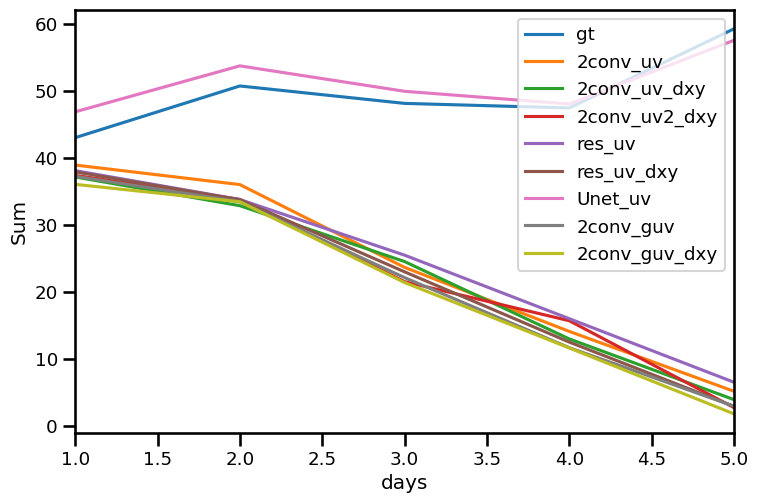

range(0, 5)

In [31]:
dss=np.zeros((9,5))
print(dss.shape)
for iax, i  in zip(axs, range(70)):
    j=indices[i%5]
    l=int(i/5)
    #print(j)
    #print(ds[l][-1,j,:,:].mean())
    dss[l,i%5]=ds[l][-1,j,:,:].sum()

    
import myfuncts 
sims=['gt','2conv_uv','2conv_uv_dxy', '2conv_uv2_dxy', 'res_uv', 'res_uv_dxy', 'Unet_uv', '2conv_guv', '2conv_guv_dxy']


plt.rcParams["figure.figsize"] = [8.50, 5.50]
a=np.arange(start=0.1, stop=1.1, step=0.1)
l=0
a=[1,2,3,4,5]
for sim in sims:
    
    plt.plot(a,dss[l,:], label=sim)
    l=l+1
    #print(sim.aloss)

plt.ylabel('Sum')
plt.xlabel('days')
plt.legend()
plt.xlim([1, 5])

plt.show()
a=range(5)
a

## uv-densities vs geo-densities (gcm_30km)

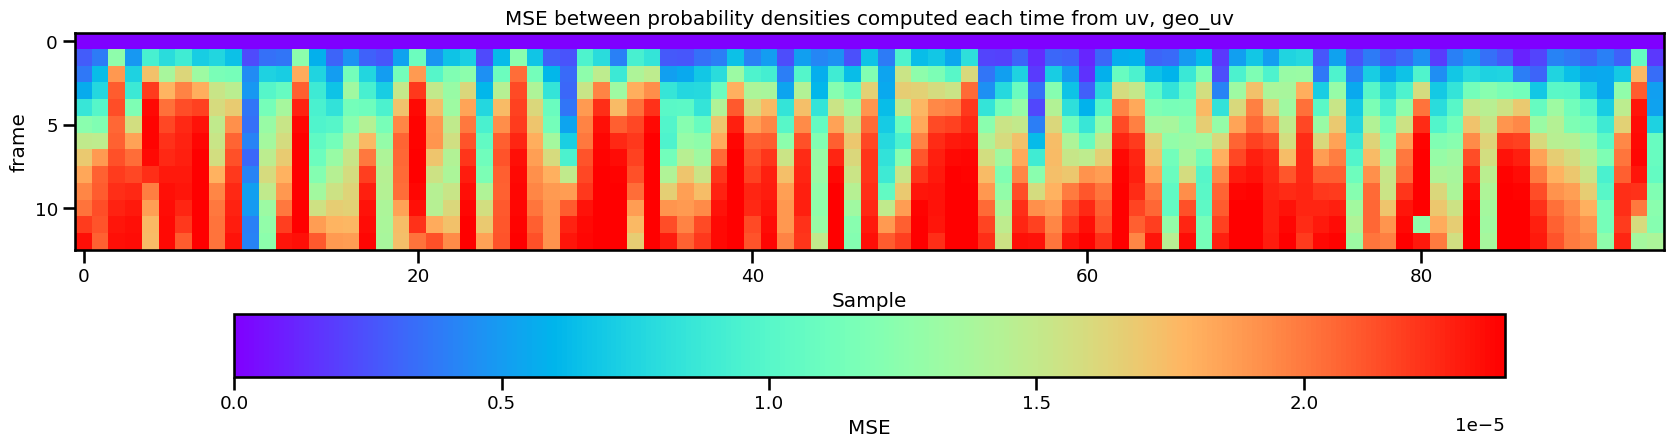

In [59]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm                                                                                                                                                                          
                                                                                                                                                                                                    
#norm = 0.43405532837                                                                                                                                                                                                    
def rmse(y1, y2):                                                                                                                                                                                   
    return np.sqrt(((y1-y2)**2)).mean()                                                                                                                                                             
                                                                                                                                                                                                    
                                                                                                                                                                                                    
rpath='~/MEOM_Workspace/data/raw/cook_coordinate/uv/density_maps/'                                                                                                                                                                          
nrpath='~/MEOM_Workspace/data/raw/cook_coordinate/guv/density_maps/'                                                                                                                                                                        
err=np.zeros((13, 95))                                                                                                                                                                              
for i in range(95):                                                                                                                                                                                 
    #print(rpath + str(i)+'.nc')                                                                                                                                                                     
    rx=xr.open_dataset(rpath + str(i)+'.nc').density_map.data                                                                                                                                       
    nrx=xr.open_dataset(nrpath + str(i)+'.nc').density_map.data                                                                                                                                     
    for j in range(13):                                                                                                                                                                             
        aa=rmse(rx[-1][j],nrx[-1][j])                                                                                                                                                               
        err[j,i]=aa
                                                                                                                                                                                                    
                                                                                                                                                                                                    
                                                                                                                                                                                                    
plt.rcParams["figure.figsize"] = [20.50, 5.50]
plt.imshow(err, cmap=cm.rainbow)   
plt.xlabel('Sample')
plt.ylabel('frame')
plt.title('MSE between probability densities computed each time from uv, geo_uv')

cbar=plt.colorbar(label="MSE", orientation="horizontal")
plt.show()

(10,)


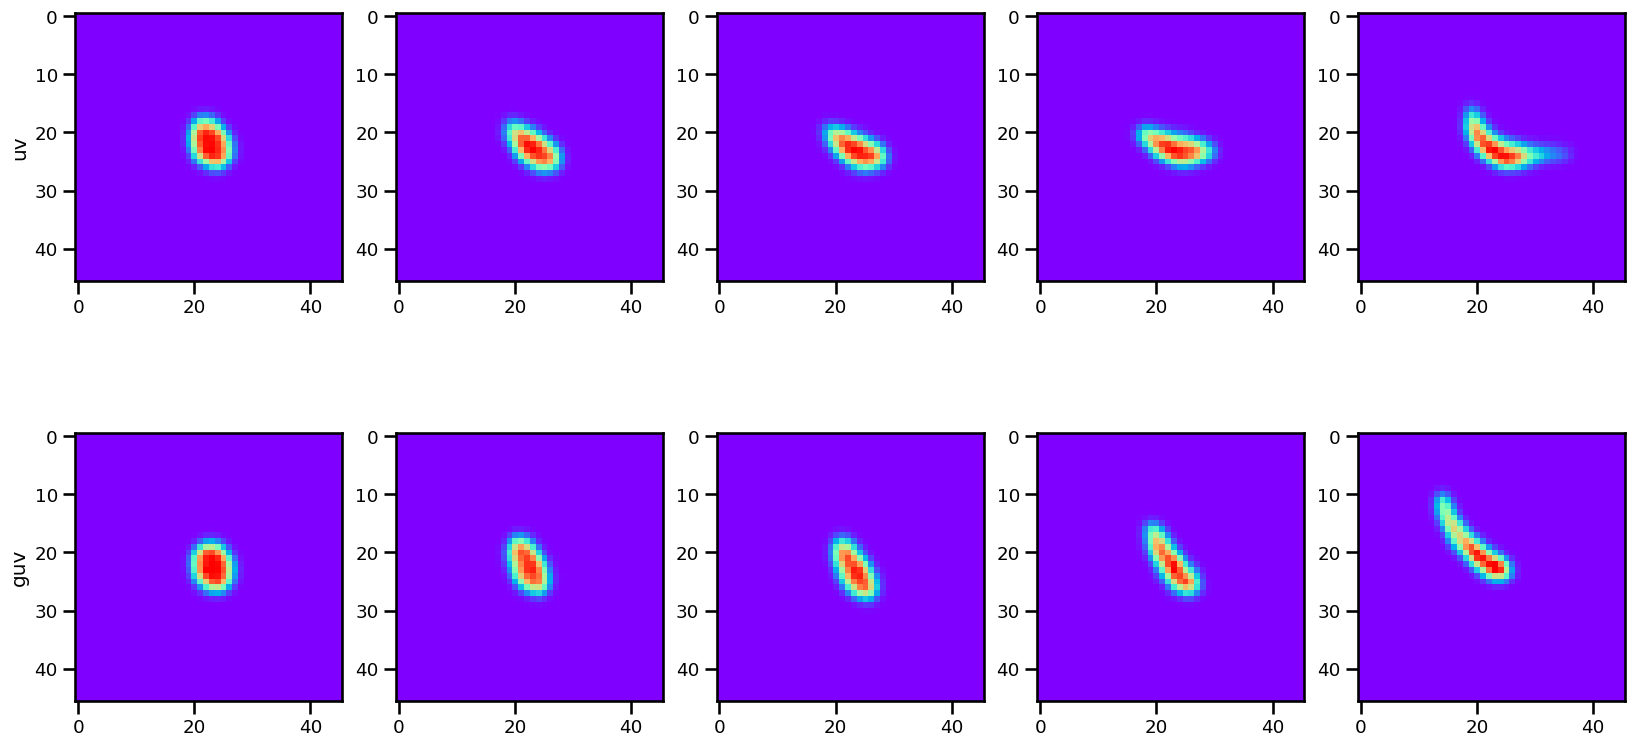

In [97]:
import myfuncts 


ds  =myfuncts.load_guv()

#ds=myfuncts.load_5d()
#ds[1][-1,2,:,:]


simulations=['uv', 'guv']
ds
mmax=1
l=0
k=23
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
axs = axs.ravel()
print(axs.shape)
j=0
# def demo_plot_and_yield():
indices=[1,3,4,6,9]
days=[1,2,3,4,5]
for iax, i  in zip(axs, range(70)):
    j=indices[i%5]
    l=int(i/5)
    #print(l,j)
    
    ind = np.unravel_index(np.argmax(ds[l][-1,j,:,:], axis=None), ds[l][-1,j,:,:].shape)
    iax.imshow(ds[l][-1,j,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                   cmap=cm.rainbow, vmin=0, vmax=mmax)
    if i%5==0 :
        iax.set_ylabel(simulations[l])
    if l>4:
        iax.set_xlabel('day ' + str(int(i%5+1)))
        
    
plt.show()

res_uv : 0.0001221591000936
Unet : 3.43431114719e-05
res_uv_dxy : 0.0001188649484119
2conv_uv_dxy_2 : 0.0001250465305942
2conv_uv2_dxy : 0.0001273750154306
2conv_guv : 0.0001254938597829
2conv_uv : 0.0001243431114719
2conv_guv_dxy : 0.0001210445288153
2conv_uv2 : 0.0001246595436605


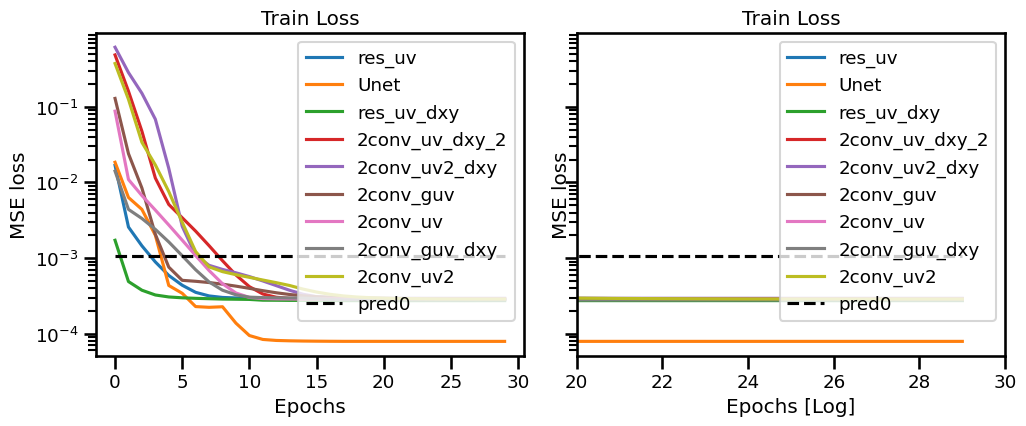

In [12]:
import myfuncts 

sims=myfuncts.load_sims()


plt.rcParams["figure.figsize"] = [10.50, 4.50]
norm = 0.43405532837#sims[0].tloss.values[0]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for sim in sims:
        ax1.plot((sim.tloss/norm),label=sim.name)
        ax2.plot((sim.tloss/norm),label=sim.name)
        print(sim.name +' :', sim.tloss[29])
        
ax1.plot(((pred0+0*sim.tloss)/norm),'k--',label='pred0')
ax1.title.set_text('Train Loss')
ax1.set_ylabel('MSE loss')
ax1.set_xlabel('Epochs')
ax1.legend()
ax1.set_yscale('log')
#ax1.set_xscale('log')

ax2.plot(((pred0+0*sim.tloss)/norm),'k--',label='pred0')
ax2.title.set_text('Train Loss')
ax2.set_ylabel('MSE loss')
ax2.set_xlabel('Epochs [Log]')
ax2.legend()
#ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlim([20, 30])
plt.tight_layout()
plt.show()

# KDL evolution

In [6]:
from scipy.special import rel_entr                                                                                                                                                                                                                                      
import numpy as np                                                                                                                                                                                                                                                      
import torch                                                                                                                                                                                                                                                            
import numpy as np                                                                                                                                                                                                                                                      
import xarray as xr                                                                                                                                                                                                                                                     
import torch.nn.functional as F                                                                                                                                                                                                                                         
import os                                                                                                                                                                                                                                                               
import matplotlib.pyplot as plt 






ds  =myfuncts.load_5ds()

ab=np.zeros((9,5))                                                                                                                                                                                                                                                    
ds
mmax=1
l=0
k=23
fig, axs = plt.subplots(ncols=5, nrows=9, figsize=(20,20))
axs = axs.ravel()
print(axs.shape)
j=0
# def demo_plot_and_yield():
indices=[4,8,12,16,20]
days=[1,2,3,4,5]
for iax, i  in zip(axs, range(90)):
    j=indices[i%5]
    l=int(i/5)
    #print(l)
    #ind = np.unravel_index(np.argmax(ds[0][-1,j,:,:], axis=None), ds[l][-1,j,:,:].shape)
    a=torch.from_numpy(ds[0][-1,j,:,:])                                                                                                                                                                                                          
    b=torch.from_numpy(ds[l][-1,j,:,:])                                                                                                                                                                                                          
    a_lsm=F.log_softmax(a)                                                                                                                                                                                                                                          
    b_sm = F.softmax(b)                                                                                                                                                                                                                                             
    out = F.kl_div(a_lsm,b_sm, None, None, 'sum')  
    #print(out)
    ab[l,i%5]=out.data
    #iax.imshow(ds[l][-1,j,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
     #              cmap=cm.rainbow, vmin=0, vmax=mmax)
        
ab[1][:]

(45,)


/tmp/ipykernel_2027776/2212588609.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  a_lsm=F.log_softmax(a)
/tmp/ipykernel_2027776/2212588609.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  b_sm = F.softmax(b)


array([0.00839922, 0.02127942, 0.04054854, 0.05081604, 0.08691256])

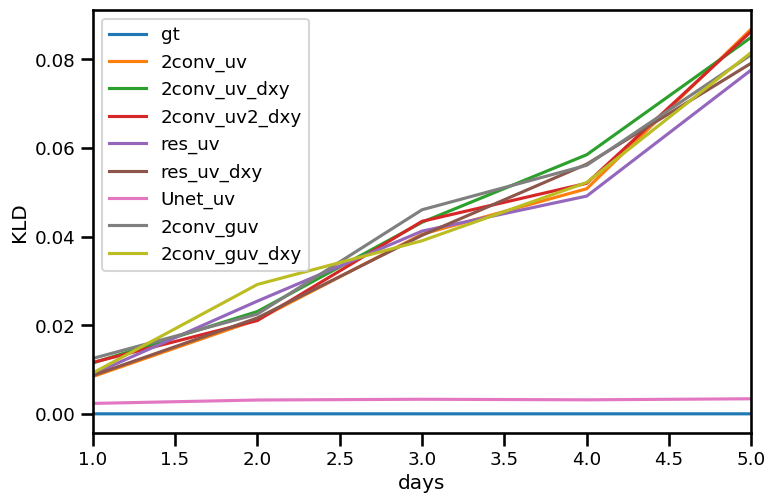

In [8]:
plt.rcParams["figure.figsize"] = [8.50, 5.50]

sims=['gt','2conv_uv','2conv_uv_dxy', '2conv_uv2_dxy', 'res_uv', 'res_uv_dxy', 'Unet_uv', '2conv_guv', '2conv_guv_dxy']

i=0
a=[1,2,3,4,5]

for sim in sims:
    plt.plot(a,ab[i][:], label=sim)
    i=i+1
    #print(sim.aloss)

plt.ylabel('KLD')
plt.xlabel('days')
plt.xlim([1, 5])
plt.legend()

plt.show()

# Learn with KDL

2conv_uv2_dxy : 0.0001273750154306
2conv_guv_dxy : 0.0001210445288153
2conv_uv : 0.0001243431114719
res_uv_dxy : 0.0001188649484119
2conv_uv_dxy_2 : 0.0001250465305942
res_uv : 0.0001221591000936
Unet : 3.43431114719e-05
KDL_uv : 0.0008515791649289
2conv_uv2 : 0.0001246595436605
2conv_guv : 0.0001254938597829


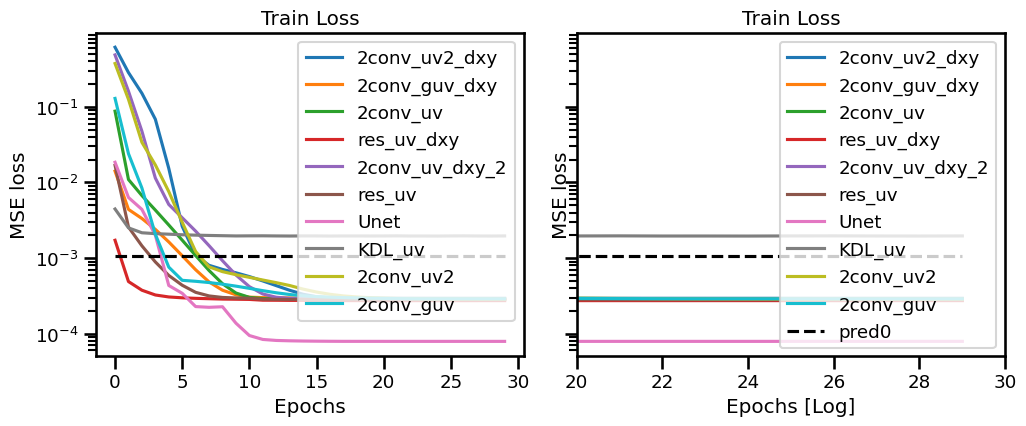

In [27]:
import myfuncts 

sims=myfuncts.load_sims3()


plt.rcParams["figure.figsize"] = [10.50, 4.50]
norm = 0.43405532837#sims[0].tloss.values[0]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for sim in sims:
        ax1.plot((sim.tloss/norm),label=sim.name)
        ax2.plot((sim.tloss/norm),label=sim.name)
        print(sim.name +' :', sim.tloss[29])
        
ax1.title.set_text('Train Loss')
ax1.set_ylabel('MSE loss')
ax1.set_xlabel('Epochs')
ax1.legend()
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax2.plot(((pred0+0*sim.tloss)/norm),'k--',label='pred0')
ax1.plot(((pred0+0*sim.tloss)/norm),'k--',label='pred0')

ax2.title.set_text('Train Loss')
ax2.set_ylabel('MSE loss')
ax2.set_xlabel('Epochs [Log]')
ax2.legend()
#ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlim([20, 30])
plt.tight_layout()
plt.show()

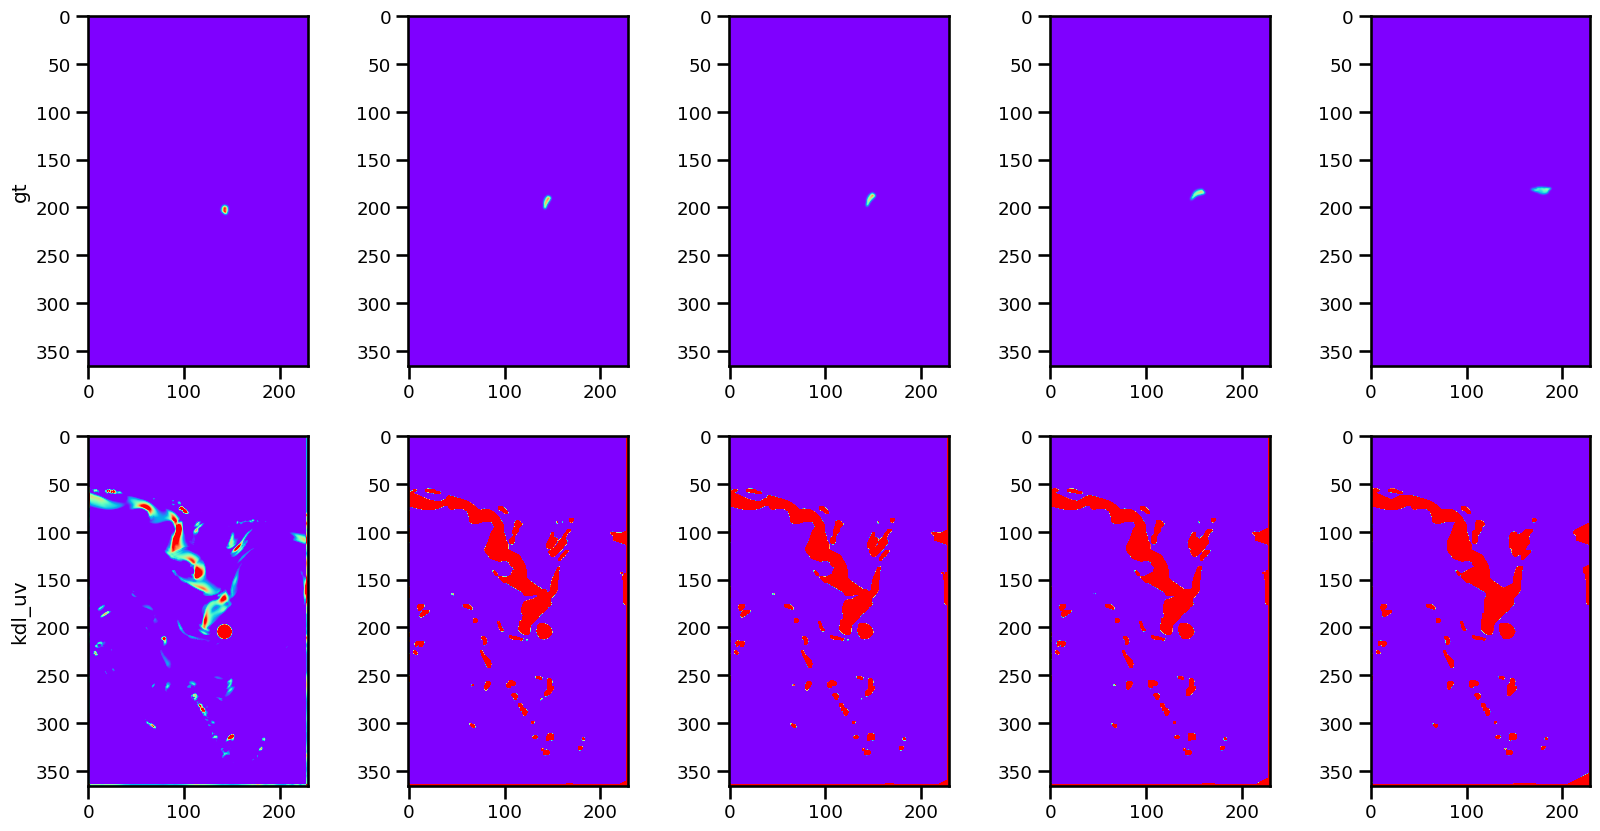

In [4]:
import myfuncts 


ds  =myfuncts.load_kdl()

#ds=myfuncts.load_5d()
#ds[1][-1,2,:,:]


simulations=['gt', 'kdl_uv']
ds
mmax=1
l=0
k=23
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
axs = axs.ravel()
#print(axs.shape)
j=0
# def demo_plot_and_yield():
indices=[0,3,4,6,11]
#days=[1,2,3,4,5]
for iax, i  in zip(axs, range(70)):
    j=indices[i%5]
    l=int(i/5)
    #print(l,j)
    
    #ind = np.unravel_index(np.argmax(ds[l][-1,j,:,:], axis=None), ds[l][-1,j,:,:].shape)
    iax.imshow(ds[l][j,-1,:,:],
                   cmap=cm.rainbow, vmin=0, vmax=mmax)
    if i%5==0 :
        iax.set_ylabel(simulations[l])
    if l>4:
        iax.set_xlabel('day ' + str(int(i%5+1)))
        
    
plt.show()